## SIMPLE KRIGING


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as LA
from scipy.spatial.distance import pdist,squareform
from PIL import Image

## DATA

In [3]:
Data = np.array(([60,80,22.45],
                 [25,50,25.3],
                 [80,10,24.74],
                 [72,72,25.89],
                 [21,78,25.67],
                 [72,72,25.89],
                 [61,98,26],
                 [21,71,24.01],
                 [10,28,19.56],
                 [76,35,23.2],
                 [23,13,26.78],
                 [50,23,25.89],
                 [60,34,26.65],
                 [24,23,26.89],
                 [89,54,24.56],
                 [35,84,21],
                 [34,65,18.78],
                 [80,23,25.6],
                 [14,97,23],
                 [87,23,23.49],
                 [24,36,24.45],
                 [52,45,24.78],
                 [89,56,27.56],
                 [15,27,25.89],
                
                ))  # Example: [x-cord, y-cord, temperature value] '''
x = []
y = []
Temp = []

for i in range(len(Data)):
    x.append(Data[i][0])
    y.append(Data[i][1])
    Temp.append(Data[i][2])
   


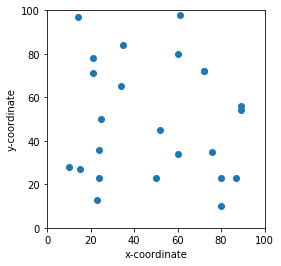

In [4]:
fig, ax = plt.subplots()
plt.scatter(x,y)
ax.set_aspect(1)
plt.xlim(0,100)
plt.ylim(0,100)
plt.xlabel('x-coordinate')
plt.ylabel('y-coordinate')
plt.show()


## MEAN AND RESIDUAL MATRIX

In [5]:
def Mean_Residual(data):
    mean = np.mean(data[:,2])
    residue = data[:,2] - mean
    return mean,residue

## DISTANCE MATRIX

In [6]:
def distance(data,num = 0,sample = [0,0]):  # here num= 0 is meant for to determin the distance between the sample points
                                        # num = 1 is meant to determine the distance between the required point with other points in the sample space
    d = np.array((data))
    if (num == 0):
        distancematrix = squareform(pdist(d[:,:-1]))
        return distancematrix
    
    if (num == 1):
        dist = []
        for i in range(len(d)):
            dist.append(np.sqrt((d[i,0] - sample[0])**2 + (d[i,1] - sample[1])**2))
        return  dist   
    
    


## SEMIVARIOGRAM

In [7]:
def Vsinglelag (data,lag,tolerance):
    dist = distance(data,0)
    
    semivariogram = []
    for i in range(dist.shape[0]):
        for j in range(i+1,dist.shape[1]):
            if ((dist[i,j] <= lag + tolerance)):
                value = (data[i][2] - data[j][2])**2
                semivariogram.append(value)
    result = 0.5*(np.sum(semivariogram))/len(semivariogram)
    return result

def Vmultiplelag (data,lags,tolerance):
    semivar = []
    for i in range(0,lags,tolerance):
        value = Vsinglelag(data,i,tolerance)
        if(np.isnan(value)):
            continue;
        else:
            value1 = (i,value)
            semivar.append(value1)
    semivar = np.array((semivar)).T
    return semivar


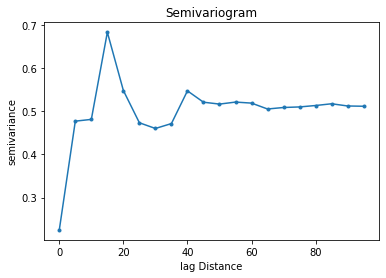

In [8]:
x = Vmultiplelag(Data,100,5)
c = x[1]/max(x[1])

plt.plot(x[0],x[1] * 0.1,'.-')

plt.xlabel('lag Distance')
plt.ylabel('semivariance')
plt.title('Semivariogram')
plt.show()



## SILL

In [9]:
def sill(data):
    variance = np.var(data[:,2]) * 0.1
    return variance;
    
a = sill(Data)
print(a)

0.48754442708333345


## RANGE

In [10]:
def Range(data, lags, tolerance):
    sill = sill(data)
    q = Vmultiplelag(data,lags,tolerance)
    for i in range(len(lags)):
        if sill <= q[1][i]:
            Range = q[0][i]
            break;
        else:
            continue
    return Range

## VARIOGRAM MODELING SPHERICAL

In [11]:
def spherical(h,a,sill):
    if type(h) == np.float64:    
        if h<=a:
            nugget = 0
            sm = nugget + (sill - nugget)*(1.5*(h/a) - 0.5*((h/a)**3))
            return sm
        else:
            sm = nugget
            return sm

## VARIOGRAM MATRIX

In [12]:
def Variogram_Mat(data,sill,Range,sample = [0,0],num = 0):
        mat = []
        mat1 = []   
        if num == 0:
            dist = distance(data,num)
            for i in range(dist.shape[0]):
                for j in range(dist.shape[0]):
                    mat.append(dist[i,j])
            for i in range (len(mat)):
                 mat1.append(spherical(mat[i],Range,sill))
            mat1 = np.reshape(mat1, (-1,dist.shape[0]))
            return mat1
    
        if num == 1:
            dist1 = distance(data,num,sample)
            for i in range (len(dist1)):
                mat.append(spherical(dist1[i],Range,sill))
            mat1 = np.reshape(mat, (len(dist1),1))
            return mat1
    

In [13]:
sample = [78,87]
k = Variogram_Mat(Data,0.8,300,sample,1)
print(k)

[[0.07714611]
 [0.25454898]
 [0.30133358]
 [0.06455951]
 [0.22797777]
 [0.06455951]
 [0.08087084]
 [0.23373799]
 [0.34930109]
 [0.20606608]
 [0.35719163]
 [0.27437759]
 [0.22129485]
 [0.32625195]
 [0.13851666]
 [0.1712316 ]
 [0.1950103 ]
 [0.25223566]
 [0.25507945]
 [0.25451948]
 [0.29103517]
 [0.19579984]
 [0.1310478 ]
 [0.3382444 ]]


## COVARIANCE MATRIX

In [14]:
def Covariance_Matrix(data,sill,Range,sample = [0,0] ,num = 0):
    if num == 0:
        vario = Variogram_Mat(data,sill,Range,sample,0)
        cov = sill - vario
        return cov
    if num == 1:
        vario = Variogram_Mat(data,sill,Range,sample,1)
        cov1 = sill - vario
        return cov1

## SIMPLE KRIGING

In [15]:
def SimpleKriging(data,sample,sill,Range):
    weights = list()
    k2 = 0
   
    
    cov_mat = Covariance_Matrix(data,sill,Range,num = 0)
    invcov = np.linalg.inv(cov_mat)
    
    covsample_mat = Covariance_Matrix(data,sill,Range,sample,num = 1)

    weightmat = invcov * np.matrix.transpose(covsample_mat)
    weightmat = np.array(weightmat)
    
    for i in range(len(weightmat)):
        weights.append(np.sum(weightmat[i,:]))
    
    print('Weight Matrix :',weights)
    print('Sum of weights is closer to one :',np.sum(weights))
    
    k1,residue = Mean_Residual(data)
    
    for i in range(len(residue)):
        k1 = k1 + (weights[i] * residue[i])
        k2 = k2 + (weights[i] * covsample_mat[i])
        
    k2 = sill - k2
    
    print('Kriging Estimate is : ',k1)
    print('Kriging Variance is : ',k2)

In [16]:
sample = [73,50]
SimpleKriging(Data,sample,0.8,300)

Weight Matrix : [0.2845774089523374, 0.03807014835983846, -0.23893698946093211, -2.0, -0.0014053248211262082, 0.0, -0.032098622141572886, -0.0034043214450223402, 0.0012047921820386165, 0.3390533777584235, -0.0020956419809978755, -0.039762374715292204, 0.11892047640385606, -0.0044515240621931795, 0.20331852341164947, 0.002971407851713792, 0.0190995436795669, -0.029874184778788226, -0.0019913905176673907, -0.014573138865545454, -0.00924136680758103, 0.1858317305899515, 0.08909483051002809, 0.0009643464331272611]
Sum of weights is closer to one : -1.0947282934641875
Kriging Estimate is :  21.006352692869175
Kriging Variance is :  [1.55397136]


## THERMAL SPATIAL IMAGES

In [17]:
def Thermal_image(data,variogram):
    t = (100,100,3)
    thermalImage = np.zeros(t,dtype =np.uint8)
    grid = np.zeros((100,100),dtype='float32')
    
    x = data[:,0]
    y = data[:,1]
    value = data[:,2]
    
    distance = np.zeros((x.shape[0],x.shape[0]))
    P = np.zeros((x.shape[0],x.shape[0]))
    
    for i in range (x.shape[0] - 1):
        distance[i,i:] = np.sqrt((x[i:]-x[i])**2+(y[i:]-y[i])**2)
        
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if distance[i,j]!=0:
                amp = np.sqrt((variogram[1])**2 +(variogram[0])**2)
                P[i,j]=value[:].var()*(1-np.e**(-3*distance[i,j]/amp))
    P = P + P.T  
    
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            
            dist = np.sqrt((i-x[:])**2+(j-y[:])**2)
            amp = np.sqrt((variogram[1])**2 +(variogram[0])**2)
            Q = value[:].var()*(1-np.e**(-3*dist[:]/amp))
            weightmat = LA.solve(P,Q)
            grid[i,j] = np.sum(weightmat*(value[:]-value[:].mean())) + value[:].mean()
            
            if (grid[i][j] >= 0 and grid[i][j] < 4):
                thermalImage[i,j] = [10,50,120]
                
            elif (grid[i][j] >= 4 and grid[i][j] < 8):
                thermalImage[i,j] = [15,75,165]
            
            elif (grid[i][j] >= 8 and grid[i][j] < 12):
                 thermalImage[i,j] = [30,110,200]
            
            elif (grid[i][j] >= 12 and grid[i][j] < 16):
                 thermalImage[i,j] = [60,160,240]
                    
            elif (grid[i][j] >= 16 and grid[i][j] < 20):
                 thermalImage[i,j] = [80,180,250]
                    
            elif (grid[i][j] >= 20 and grid[i][j] < 21):
                 thermalImage[i,j] = [160,240,255]
            
            elif (grid[i][j] >= 21 and grid[i][j] < 22):
                 thermalImage[i,j] = [200,250,255]
                    
            elif (grid[i][j] >= 22 and grid[i][j] < 23):
                 thermalImage[i,j] = [230,255,255]
                    
            elif (grid[i][j] >= 23 and grid[i][j] < 24):
                 thermalImage[i,j] = [255,250,220]
                    
            elif (grid[i][j] >= 24 and grid[i][j] < 25):
                 thermalImage[i,j] = [255,232,120]
                    
            elif (grid[i][j] >= 25 and grid[i][j] < 26):
                 thermalImage[i,j] = [255,192,60]
                    
            elif (grid[i][j] >= 26 and grid[i][j] < 27):
                 thermalImage[i,j] = [255,160,0]
                    
            elif (grid[i][j] >= 27 and grid[i][j] < 28):
                 thermalImage[i,j] = [255,96,0]
                    
            elif (grid[i][j] >= 28 and grid[i][j] < 29):
                 thermalImage[i,j] = [255,50,0]
                    
            elif (grid[i][j] >= 29 and grid[i][j] < 30):
                 thermalImage[i,j] = [255,20,0]
                    
            elif (grid[i][j] >= 30 and grid[i][j] < 31):
                 thermalImage[i,j] = [192,0,0]
                    
            elif (grid[i][j] >= 31):
                 thermalImage[i,j] = [165,0,0]
                    
    i = Image.fromarray(thermalImage,"RGB")
    
    i.show()
    
Thermal_image(Data,(50,30));   
    

C:\Users\Eeshwar\Anaconda3\envs\tensorflow-sessions\lib\site-packages\ipykernel_launcher.py:29: LinAlgWarning: Ill-conditioned matrix (rcond=1.91821e-34): result may not be accurate.
